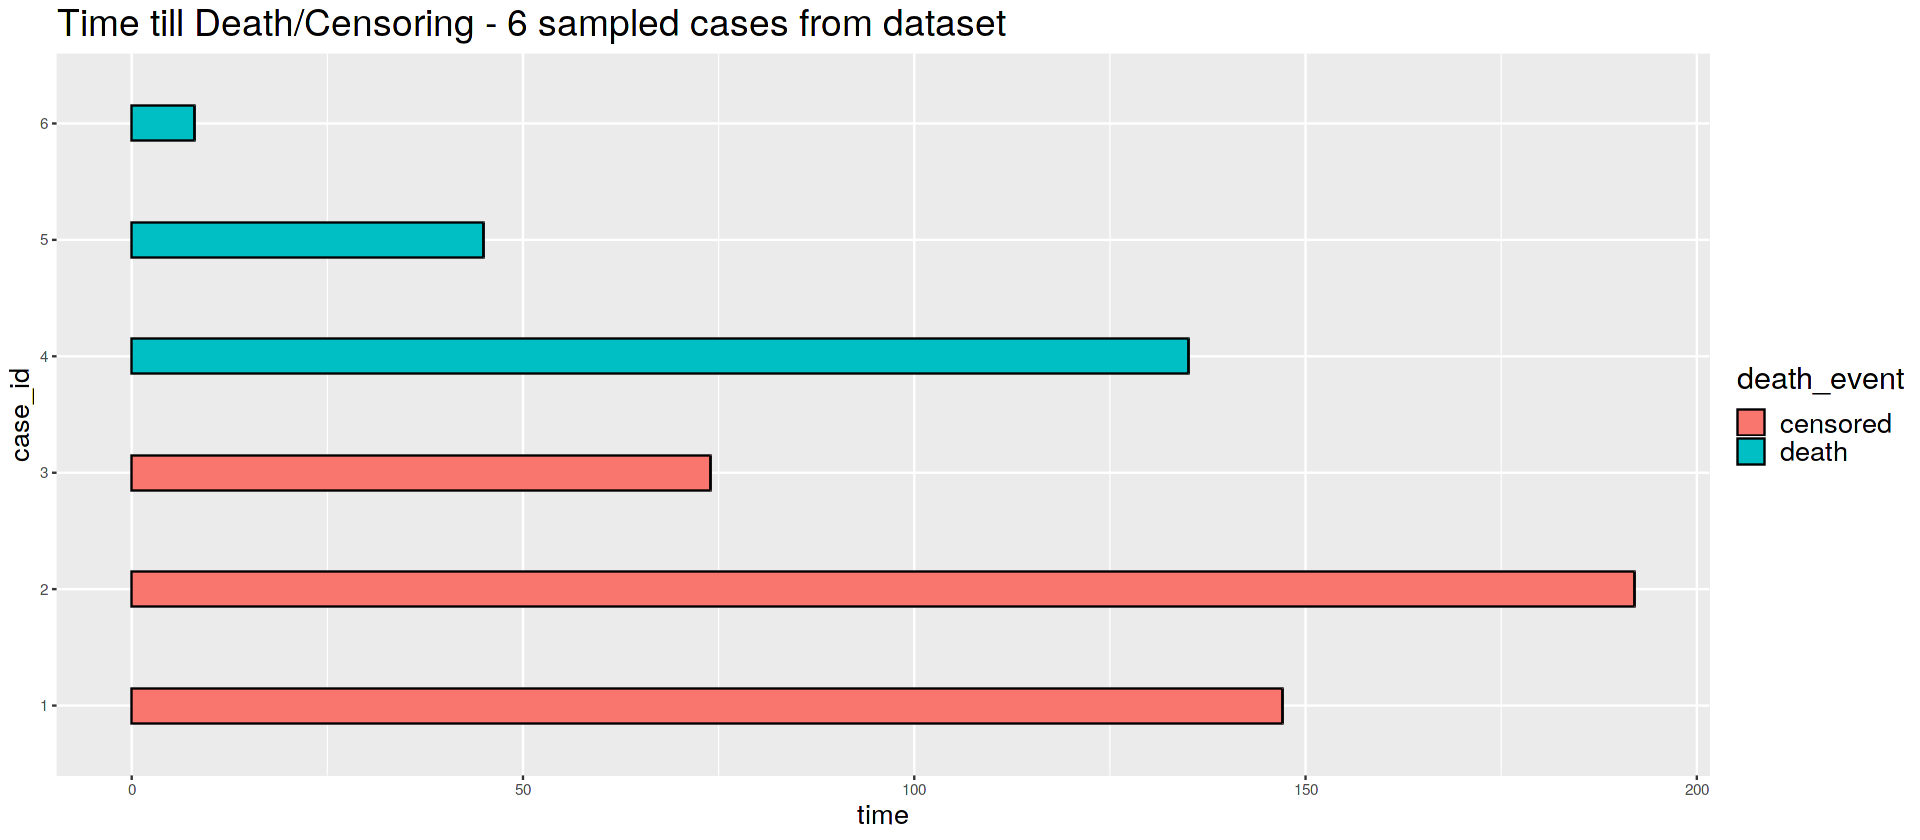

In [1]:
# Libraries for analysis
suppressMessages(library(tidyverse))
suppressMessages(library(survival))
suppressMessages(suppressWarnings(library(survminer)))

# Plotting options
options(repr.plot.width = 16, repr.plot.height = 7)

# Read data
all_df <- read_csv('../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv', col_type = cols())

# Sample 3 + 3 points from death/censored groups, and plot them for comparison
plot_censoring <- all_df %>% group_by(DEATH_EVENT) %>% sample_n(3) %>% ungroup() %>% select(time, DEATH_EVENT)

plot_censoring %>%
    mutate(
        time_start = 0, 
        case_id = factor(c(1:nrow(plot_censoring))),
        death_event = factor(ifelse(DEATH_EVENT == 1, "death", "censored"))
    ) %>%
    pivot_longer(
        cols = c(time, time_start),
        names_to = "source",
        values_to = "time"
    ) %>%
    ggplot(aes(x = time, y = case_id, group = factor(case_id))) + 
    geom_bar(stat = "Identity", aes(fill = death_event), colour = "black", width = 0.3) +
    ggtitle("Time till Death/Censoring - 6 sampled cases from dataset") + 
    theme(plot.title = element_text(size = 22), 
          legend.title = element_text(size = 18), 
          legend.text = element_text(size = 16), 
          axis.title = element_text(size = 16))

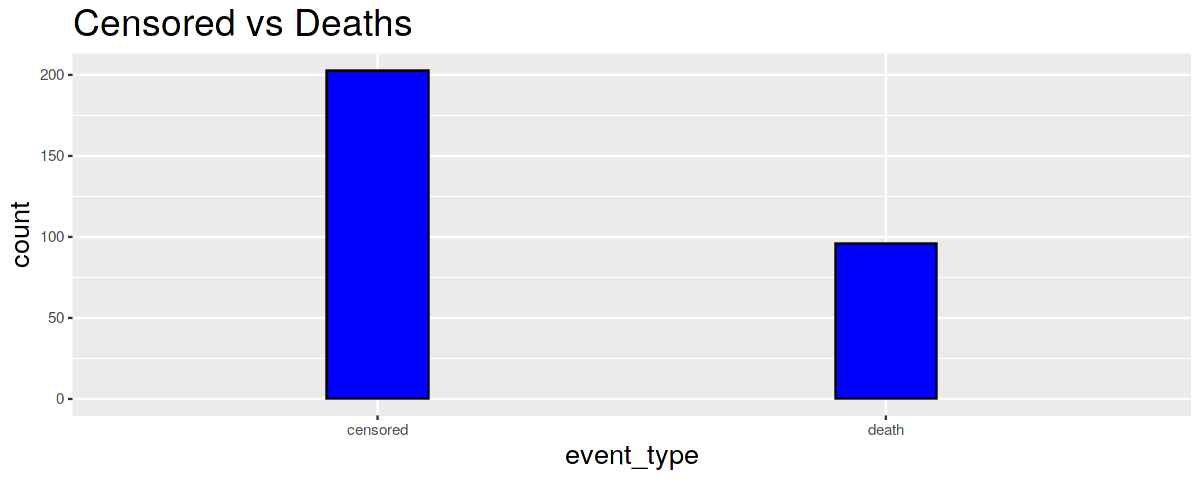

In [2]:
# Censoring vs Death
options(repr.plot.width = 10, repr.plot.height = 4)

all_df %>%
    mutate(event_type = factor(ifelse(DEATH_EVENT == 1, "death", "censored"))) %>%
    group_by(event_type) %>%
    tally(name = "count") %>%
    ggplot(aes(x = event_type, y = count)) + 
    geom_bar(stat = "Identity", fill = "blue", width = 0.2, colour = "black") +
    ggtitle("Censored vs Deaths") + 
    theme(plot.title = element_text(size = 22),  
          axis.title = element_text(size = 16))

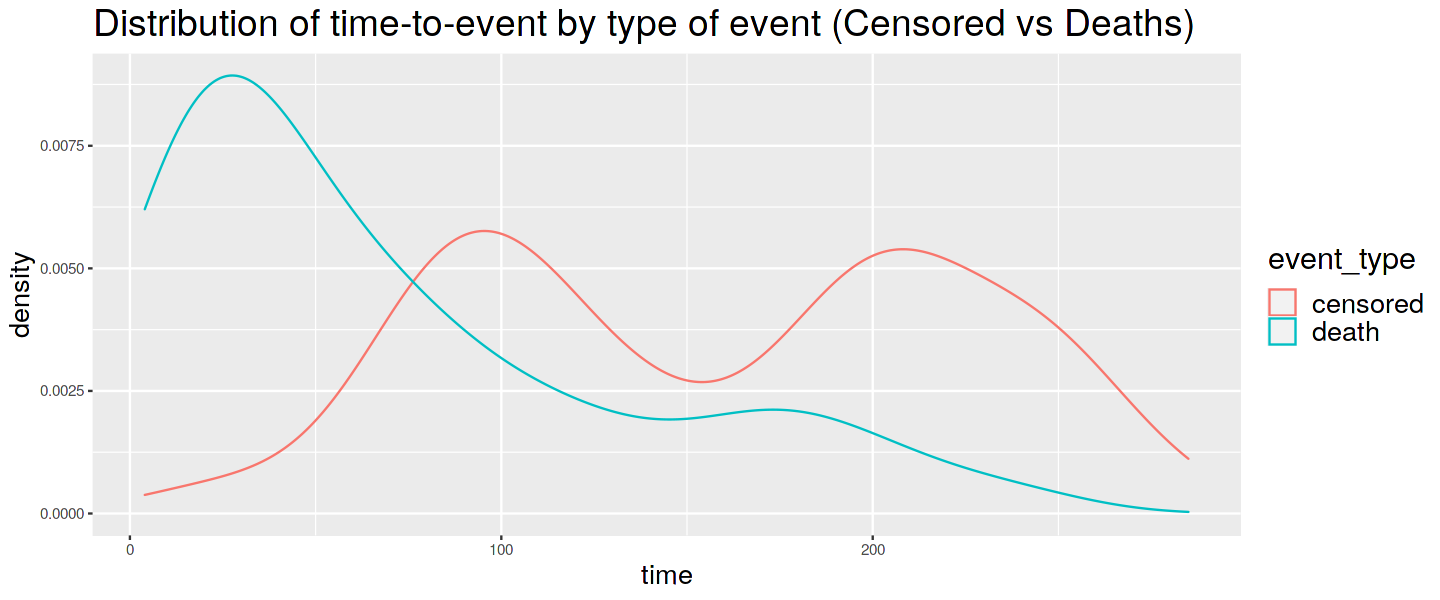

In [3]:
# Distribution of time-to-event by event type
options(repr.plot.width = 12, repr.plot.height = 5)

all_df %>%
    mutate(
        event_type = factor(ifelse(DEATH_EVENT == 1, "death", "censored"))
    ) %>%
    select(event_type, time) %>%
    ggplot(aes(x = time, colour = event_type)) + 
    geom_density() + 
    ggtitle("Distribution of time-to-event by type of event (Censored vs Deaths)") + 
    theme(plot.title = element_text(size = 22),  
          axis.title = element_text(size = 16), 
          legend.title = element_text(size = 18), 
          legend.text = element_text(size = 16))

In [4]:
# Kaplan-meier analysis
km_model <- survfit(Surv(time, DEATH_EVENT) ~ 1, data = all_df)
summary(km_model, times = seq(from = 0, to = 290, by = 30))

Call: survfit(formula = Surv(time, DEATH_EVENT) ~ 1, data = all_df)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    0    299       0    1.000  0.0000        1.000        1.000
   30    264      35    0.882  0.0187        0.846        0.920
   60    239      19    0.817  0.0225        0.774        0.863
   90    189      15    0.763  0.0250        0.715        0.813
  120    145       7    0.730  0.0268        0.680        0.785
  150    118       5    0.703  0.0285        0.649        0.761
  180    106       8    0.654  0.0313        0.596        0.719
  210     62       4    0.622  0.0337        0.559        0.692
  240     34       2    0.594  0.0378        0.524        0.673
  270      6       1    0.576  0.0407        0.501        0.661

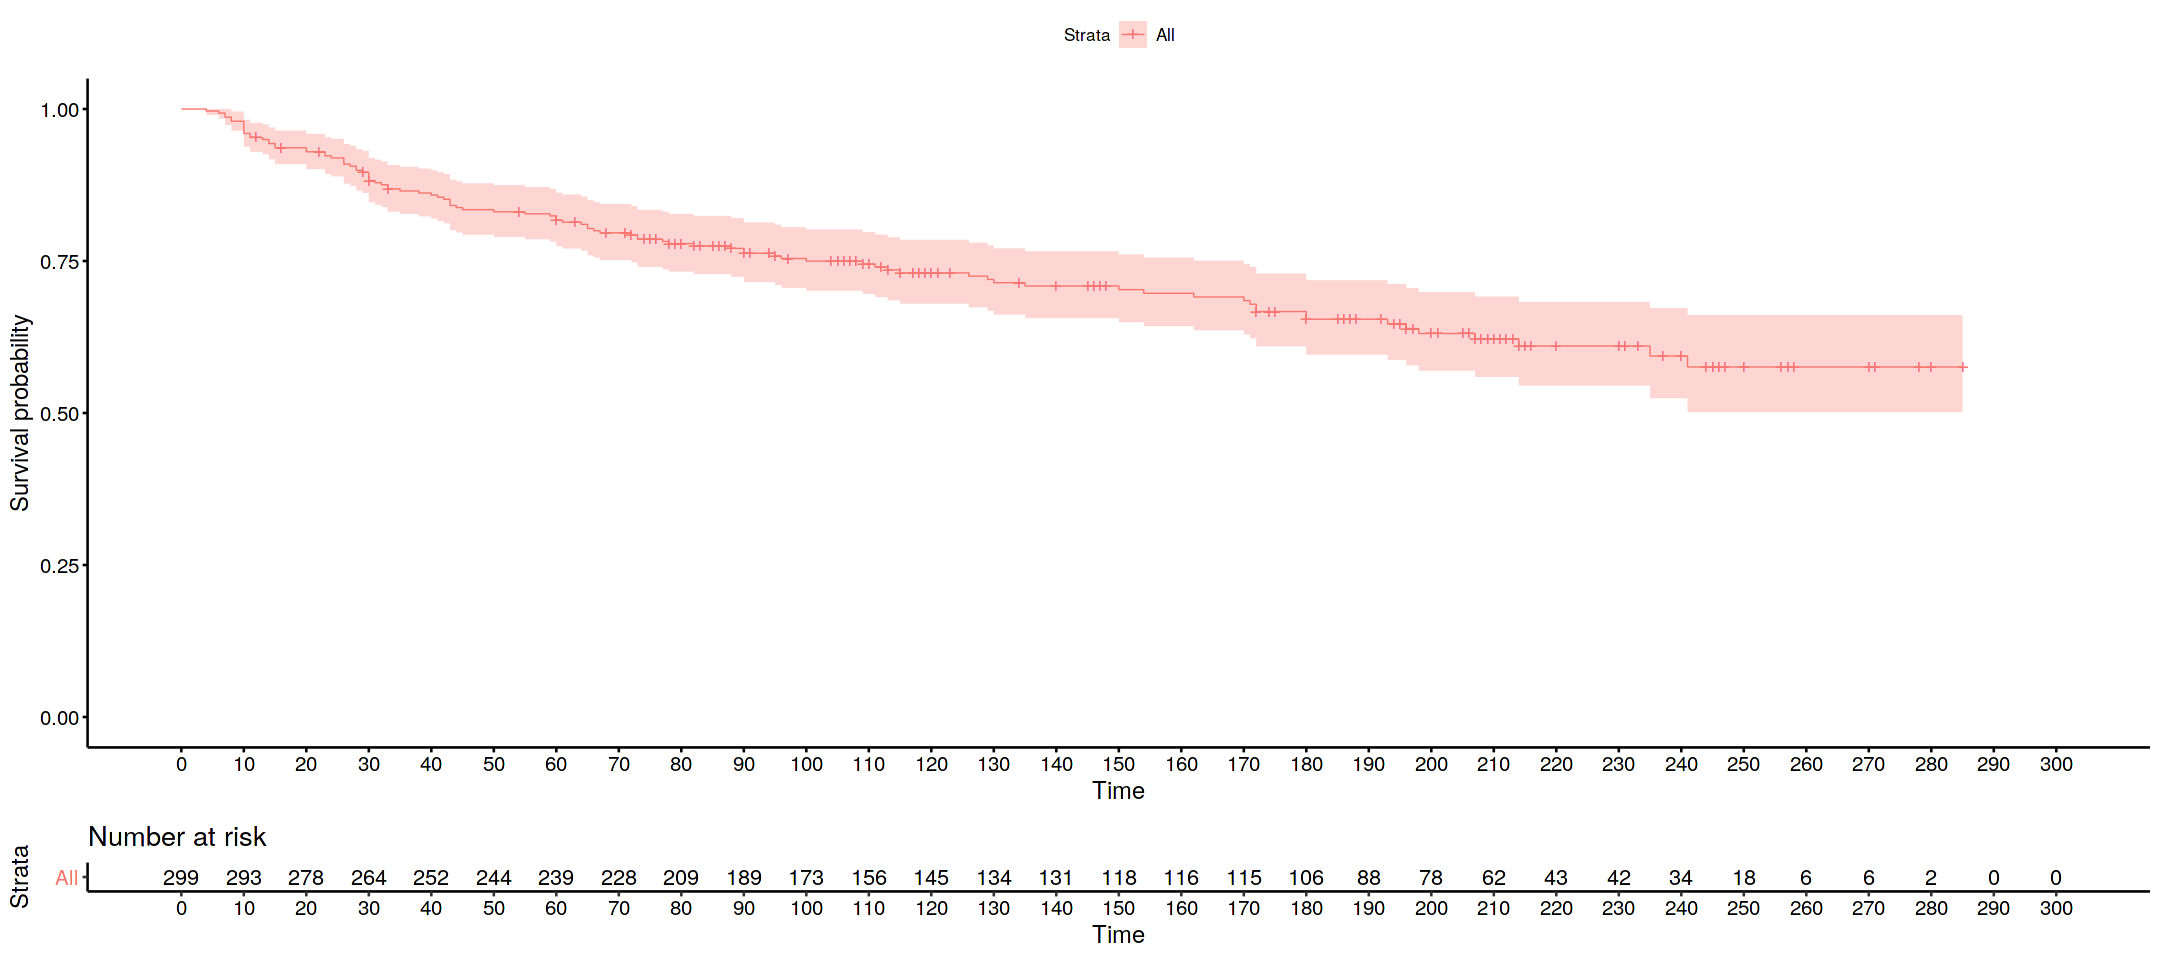

In [5]:
# Plot Kaplan-Meier plot
options(repr.plot.width = 18, repr.plot.height = 8)

ggsurvplot(km_model, data = all_df, risk.table = TRUE, 
           break.time.by = 10, size = 0.3, tables.height = 0.15)

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


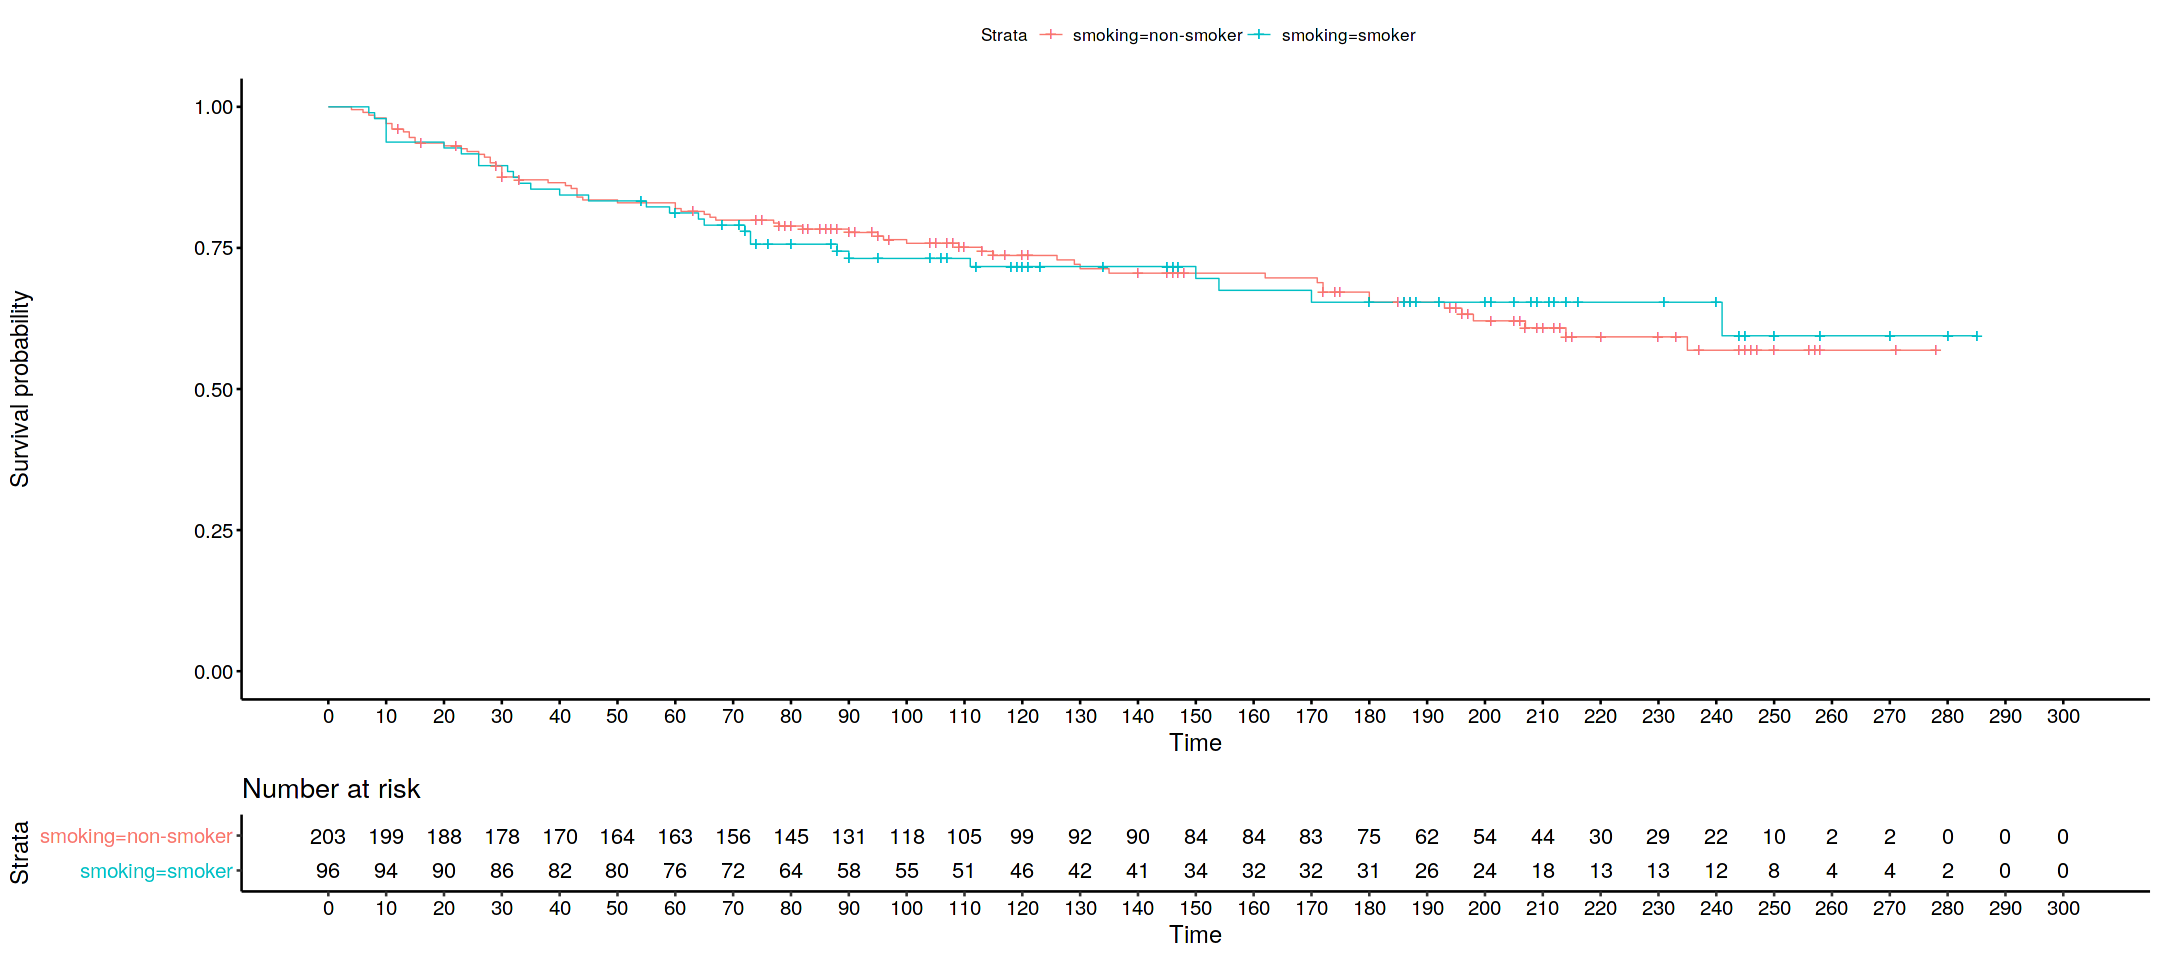

In [6]:
# Kaplan-Meier curve based on presence/absence of smoking
km_model <- all_df %>%
    mutate(
        smoking = factor(ifelse(smoking == 0, "non-smoker", "smoker"))
    ) %>%
    survfit(Surv(time, DEATH_EVENT) ~ smoking, data = .)

ggsurvplot(km_model, data = all_df, risk.table = TRUE, 
           break.time.by = 10, size = 0.3, tables.height = 0.20)



## Cox Proportional Hazards Model


In [7]:
# Change columns into factors and scale columns to enable better model fit
all_df <- all_df %>% 
    mutate(
        anaemia = factor(ifelse(anaemia == 1, "anaemic", "non-anaemic"), levels = c("non-anaemic", "anaemic")),
        diabetes = factor(ifelse(diabetes == 1, "diabetic", "non-diabetic"), levels = c("non-diabetic", "diabetic")),
        high_blood_pressure = factor(ifelse(high_blood_pressure == 1, "high-bp", "non-high-bp"), levels = c("non-high-bp", "high-bp")),
        sex = factor(ifelse(sex == 0, "female", "male"), levels = c("female", "male")),
        smoking = factor(ifelse(smoking == 0, "non-smoker", "smoker"), levels = c("non-smoker", "smoker")),
        platelets = platelets/1e4, 
        creatinine_phosphokinase = creatinine_phosphokinase/1e3
    )

In [8]:
all_df %>% head

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
75,non-anaemic,0.582,non-diabetic,20,high-bp,26.5000,1.9,130,male,non-smoker,4,1
55,non-anaemic,7.861,non-diabetic,38,non-high-bp,26.3358,1.1,136,male,non-smoker,6,1
65,non-anaemic,0.146,non-diabetic,20,non-high-bp,16.2000,1.3,129,male,smoker,7,1
50,anaemic,0.111,non-diabetic,20,non-high-bp,21.0000,1.9,137,male,non-smoker,7,1
65,anaemic,0.160,diabetic,20,non-high-bp,32.7000,2.7,116,female,non-smoker,8,1
90,anaemic,0.047,non-diabetic,40,high-bp,20.4000,2.1,132,male,smoker,8,1


In [9]:
# Cox proportional hazard model
cox_model <- coxph(Surv(time, DEATH_EVENT) ~ age + anaemia + creatinine_phosphokinase + diabetes + ejection_fraction + 
                   high_blood_pressure + platelets + smoking + sex, 
                   data = all_df)
summary(cox_model)

Call:
coxph(formula = Surv(time, DEATH_EVENT) ~ age + anaemia + creatinine_phosphokinase + 
    diabetes + ejection_fraction + high_blood_pressure + platelets + 
    smoking + sex, data = all_df)

  n= 299, number of events= 96 

                                coef exp(coef)  se(coef)      z Pr(>|z|)    
age                         0.048866  1.050079  0.009154  5.338 9.39e-08 ***
anaemiaanaemic              0.395116  1.484556  0.210633  1.876   0.0607 .  
creatinine_phosphokinase    0.167006  1.181761  0.100425  1.663   0.0963 .  
diabetesdiabetic            0.070908  1.073483  0.215029  0.330   0.7416    
ejection_fraction          -0.053933  0.947496  0.011173 -4.827 1.39e-06 ***
high_blood_pressurehigh-bp  0.482632  1.620334  0.214730  2.248   0.0246 *  
platelets                  -0.009633  0.990413  0.011328 -0.850   0.3951    
smokingsmoker               0.051413  1.052757  0.249994  0.206   0.8371    
sexmale                    -0.173410  0.840793  0.250258 -0.693   0.4884    




## Using the Cox Proportional Hazards model



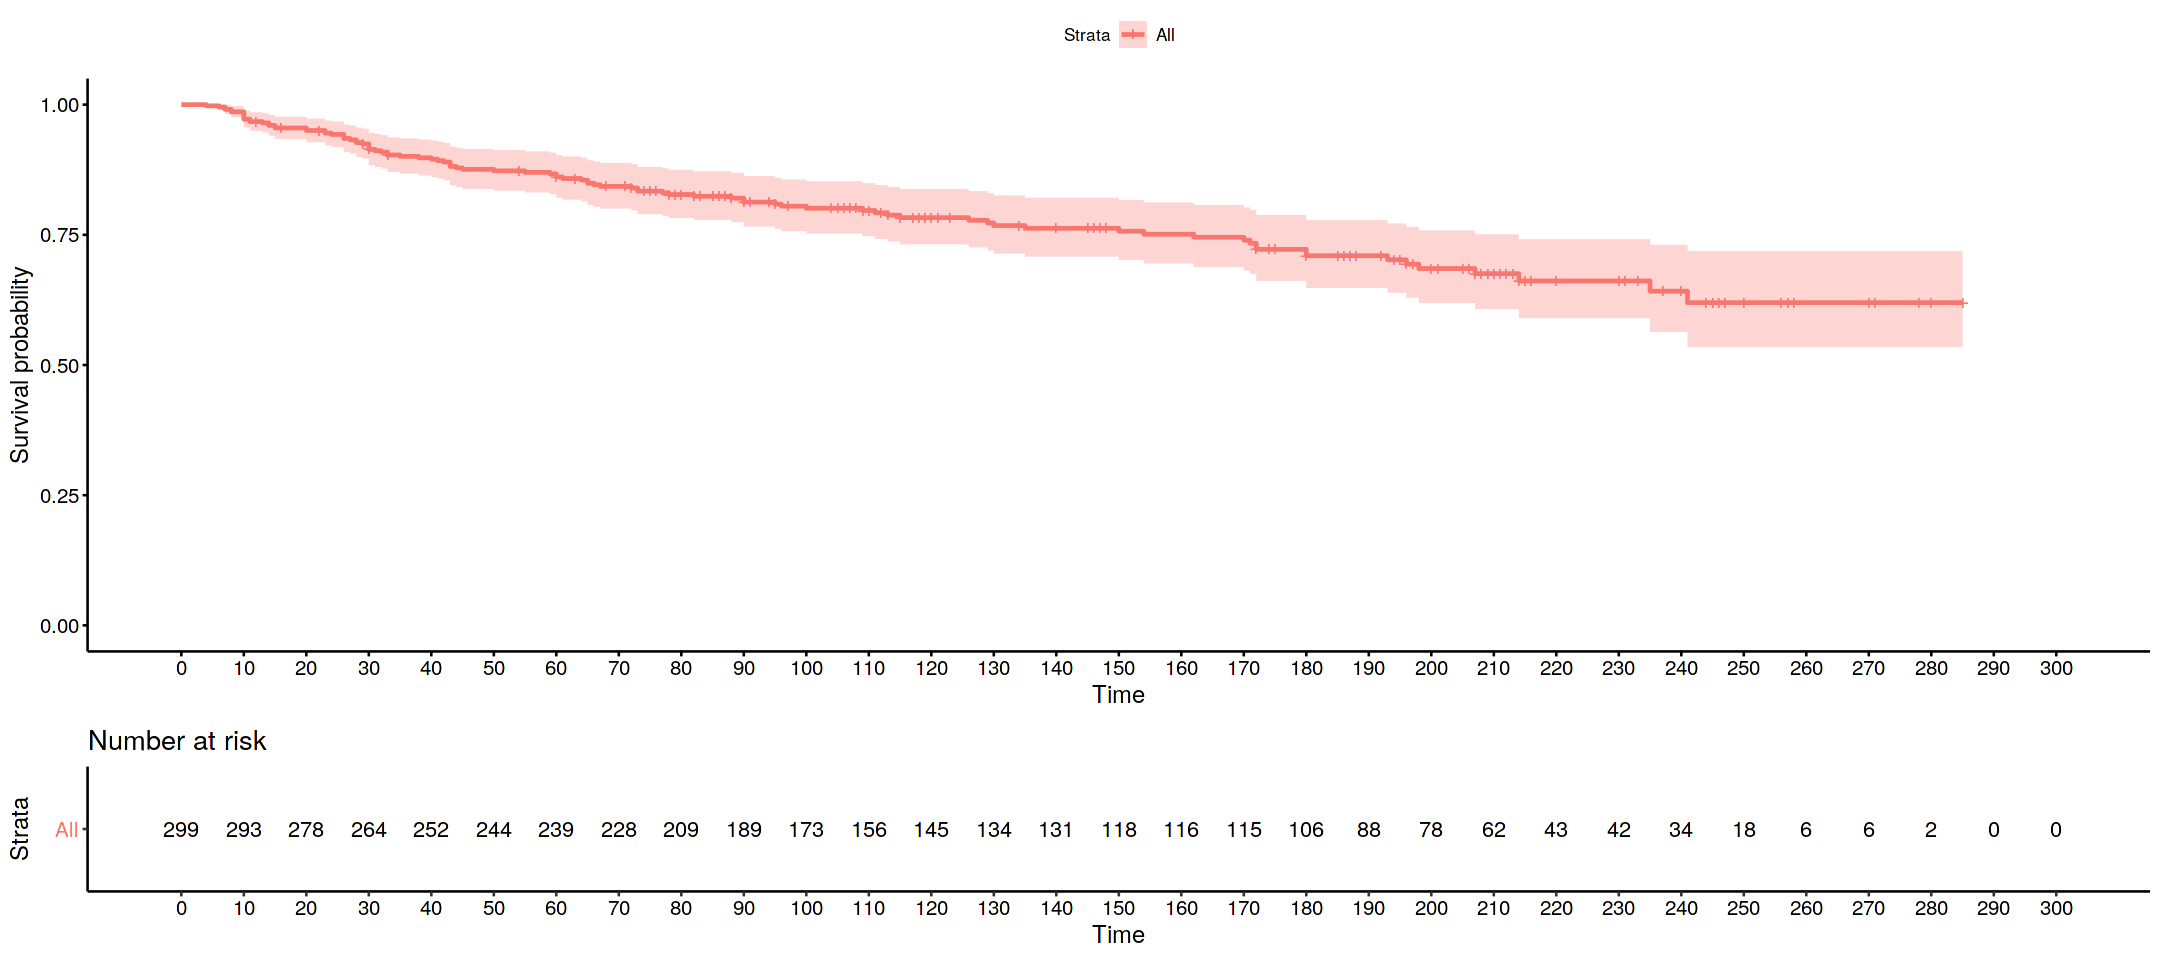

In [10]:
# Plot the survival for a population with mean value of covariates
ggsurvplot(survfit(cox_model), data = all_df, risk.table = TRUE, break.time.by = 10)

We can compare the survival of 2 groups of populations as well.


In [11]:
# A data-set with 2 rows. 1 row per factor level. Numerical covariates are set to median value.
compare_smoking_median_age <- tibble(
    age = rep(median(all_df$age), 2), 
    anaemia = factor(c("anaemic", "non-anaemic"), levels = levels(all_df$anaemia)),
    creatinine_phosphokinase = rep(median(all_df$creatinine_phosphokinase), 2),
    diabetes = factor(c("diabetic", "non-diabetic"), levels = levels(all_df$diabetes)),
    ejection_fraction = rep(median(all_df$ejection_fraction), 2),
    high_blood_pressure = factor(c("high-bp", "non-high-bp"), levels = levels(all_df$high_blood_pressure)),
    platelets = rep(median(all_df$platelets), 2), 
    smoking = factor(c("smoker", "non-smoker"), levels = levels(all_df$smoking)), 
    sex = factor(c("male", "female"), levels = levels(all_df$sex)),
)

compare_smoking_median_age

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,smoking,sex
<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>
60,anaemic,0.25,diabetic,38,high-bp,26.2,smoker,male
60,non-anaemic,0.25,non-diabetic,38,non-high-bp,26.2,non-smoker,female


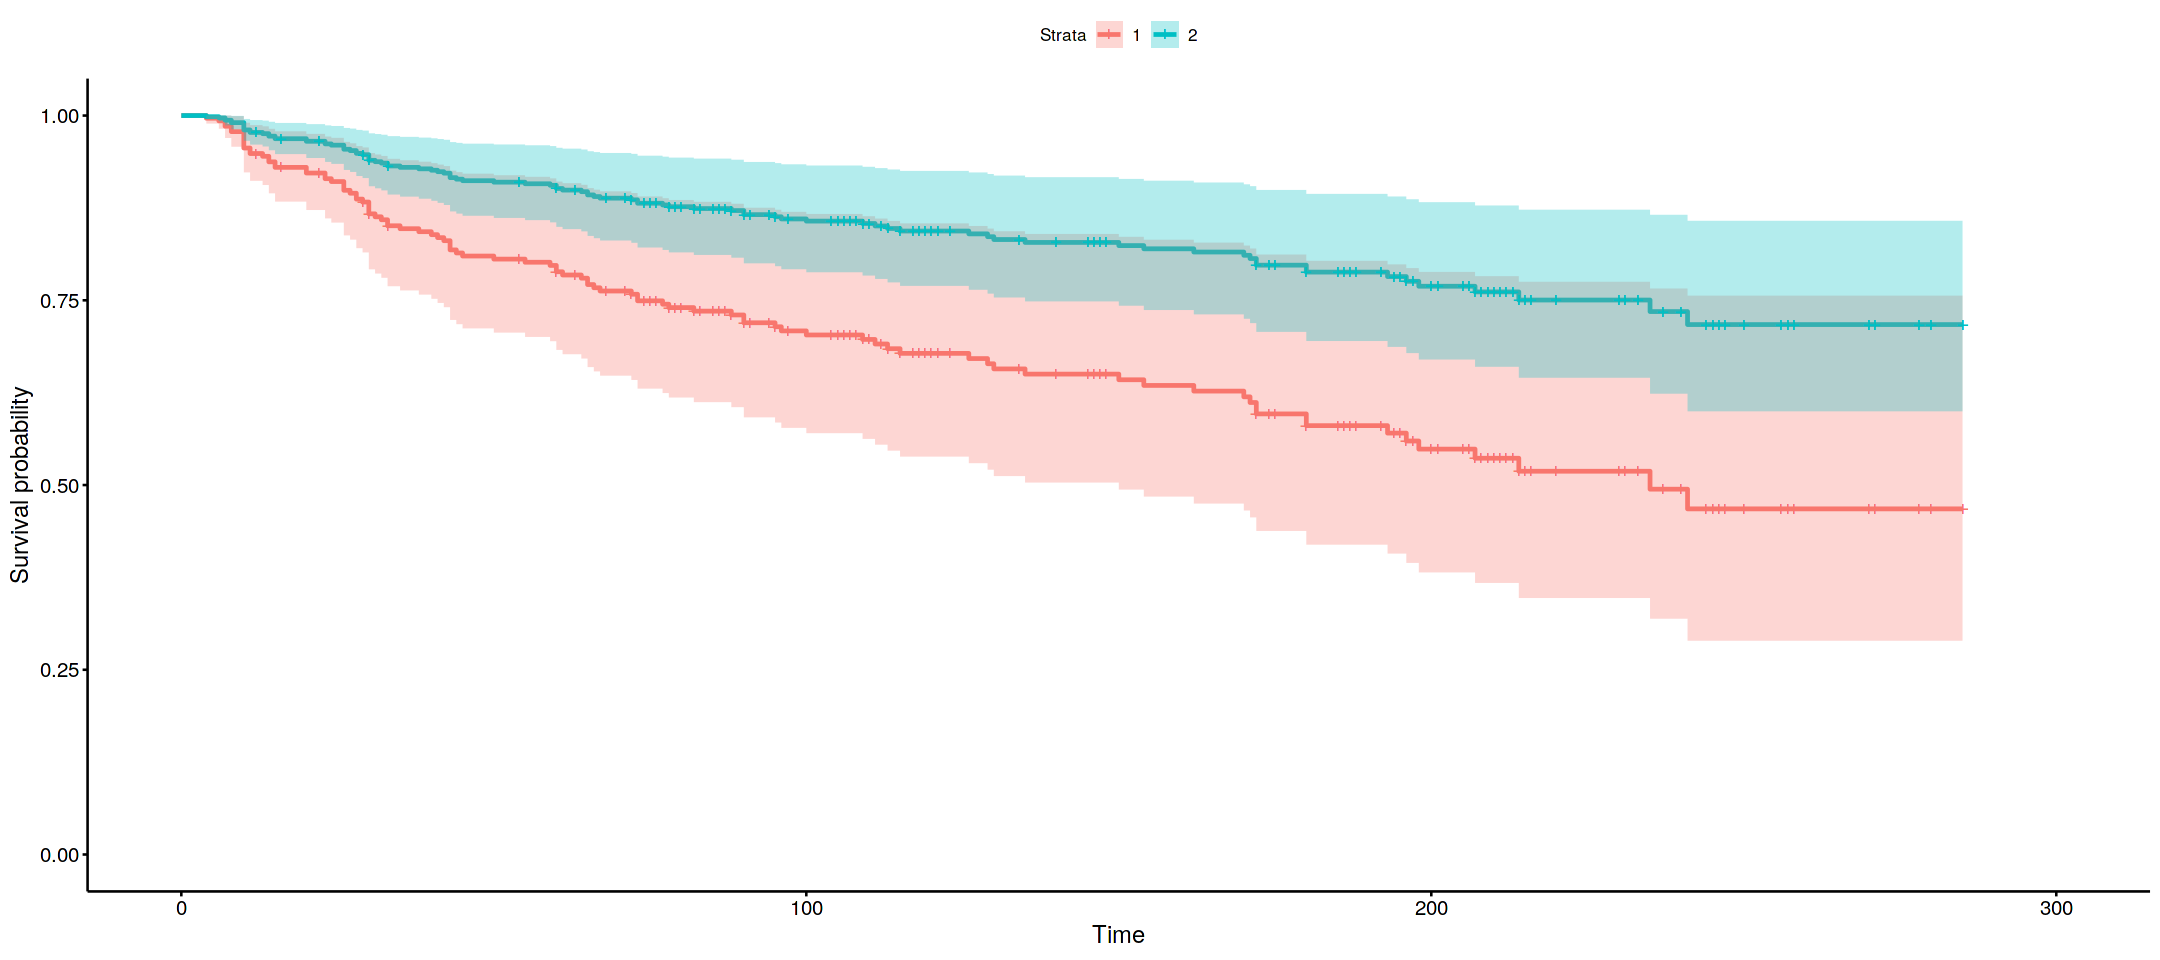

In [12]:
ggsurvplot(survfit(cox_model, data = compare_smoking_median_age, newdata = compare_smoking_median_age), conf.int = TRUE)

In [13]:
cox.zph(cox_model)

                          chisq df     p
age                      0.7713  1 0.380
anaemia                  0.2858  1 0.593
creatinine_phosphokinase 0.7315  1 0.392
diabetes                 0.1268  1 0.722
ejection_fraction        5.6415  1 0.018
high_blood_pressure      0.0895  1 0.765
platelets                0.1005  1 0.751
smoking                  0.4923  1 0.483
sex                      0.3095  1 0.578
GLOBAL                   8.7353  9 0.462

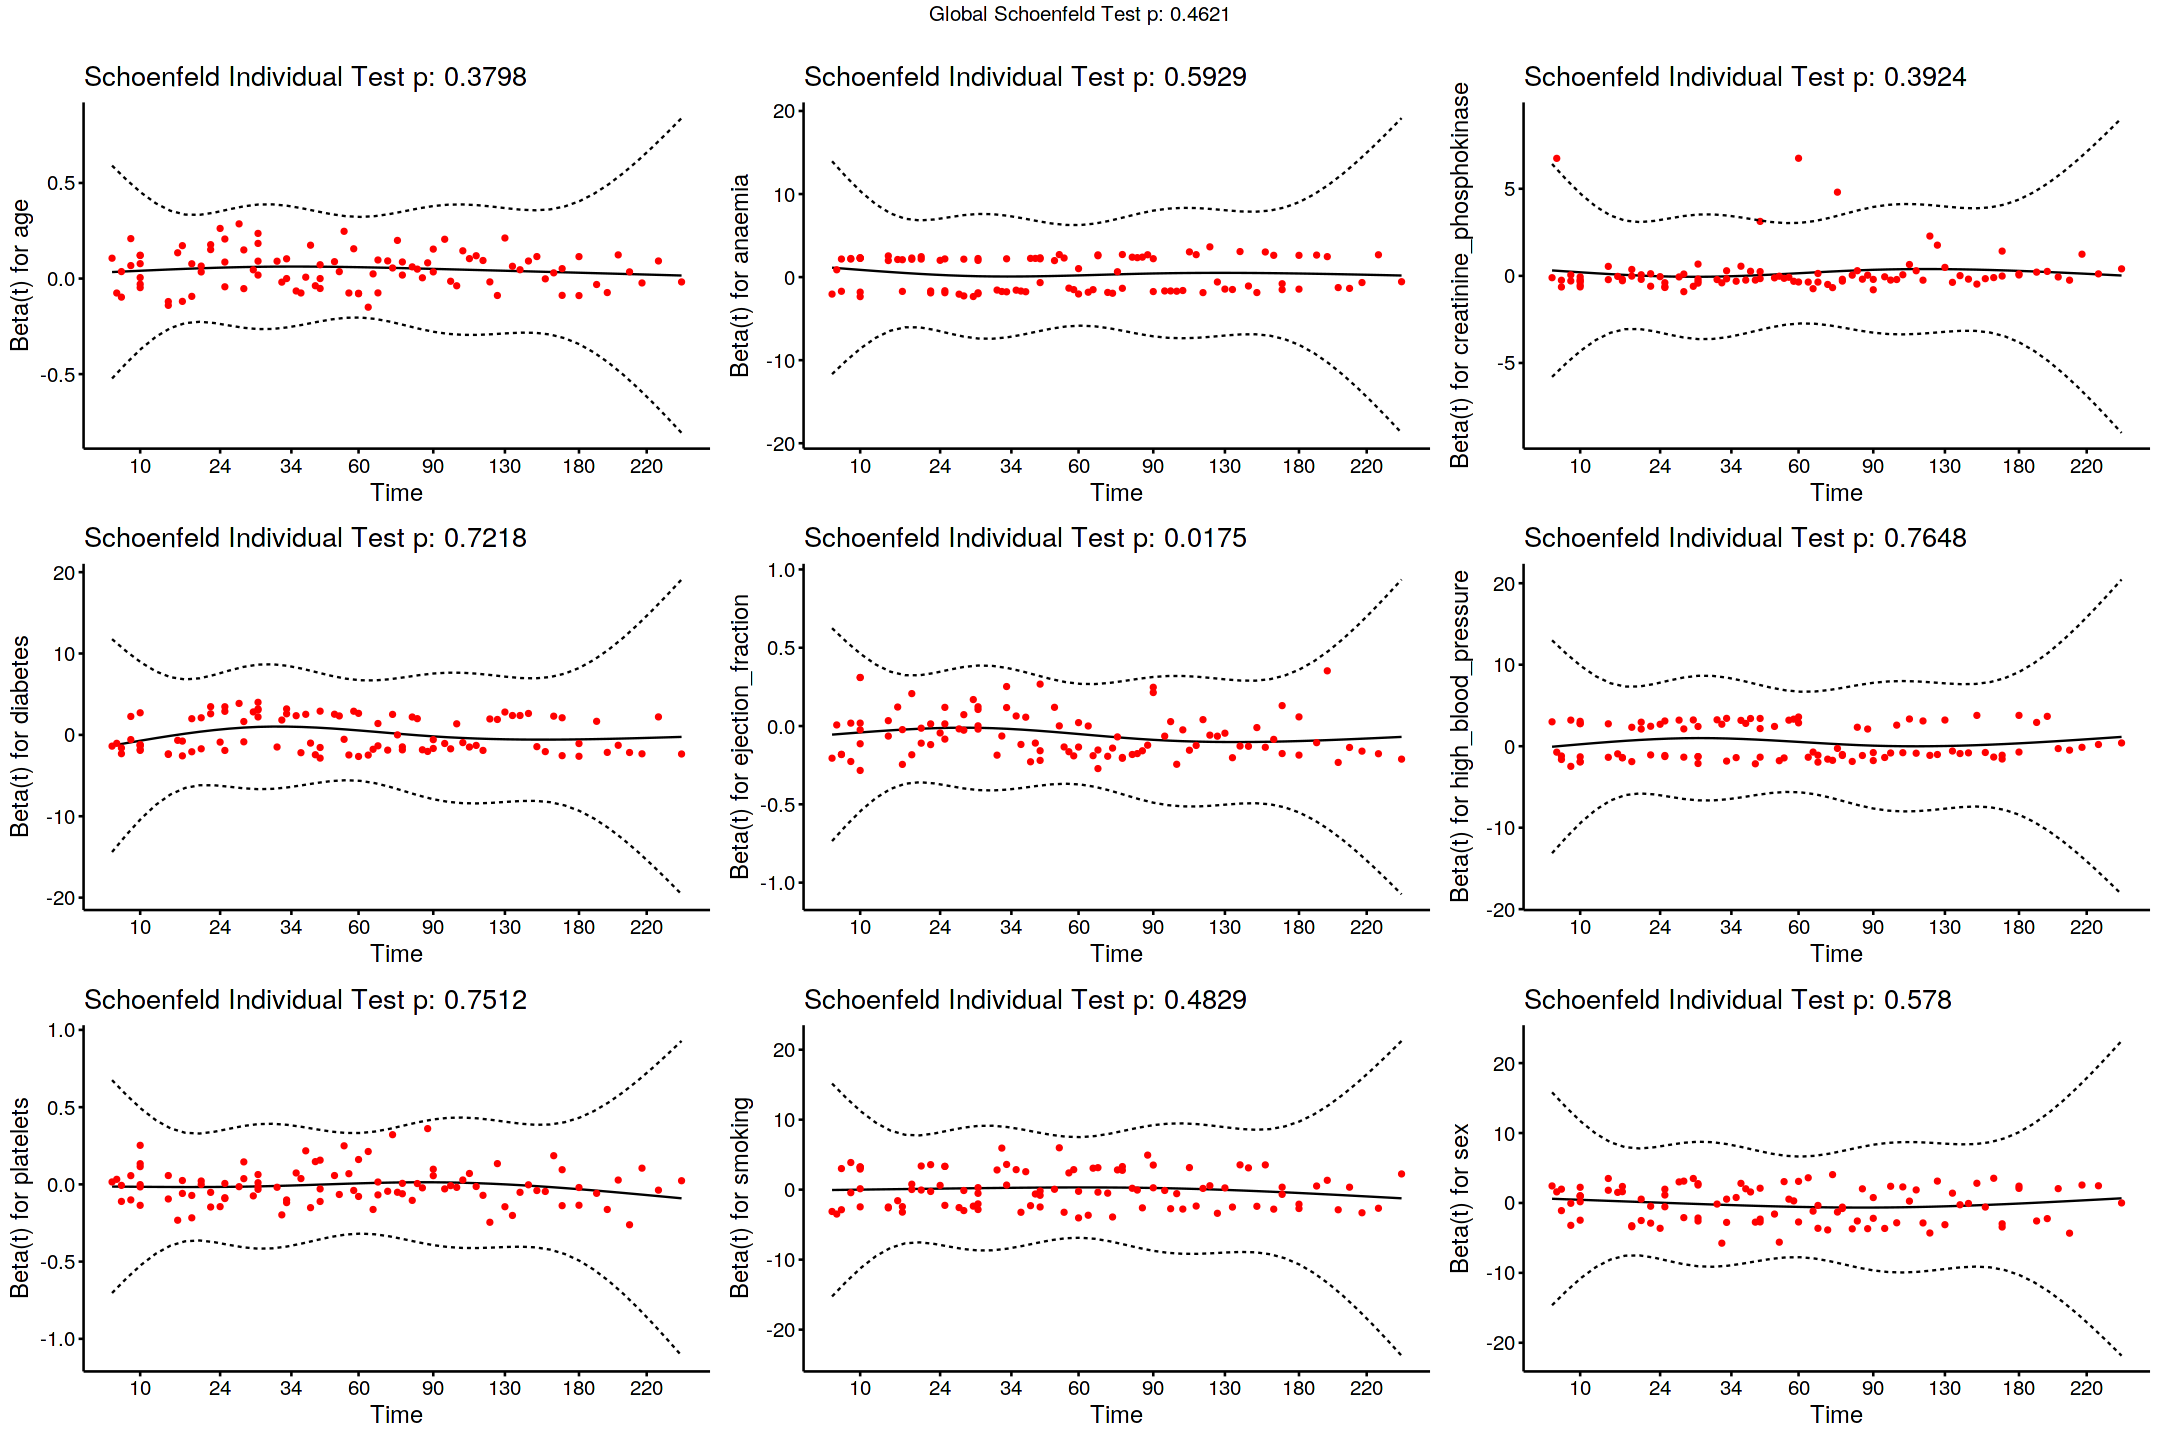

In [14]:
options(repr.plot.width = 18, repr.plot.height = 12)
ggcoxzph(cox.zph(cox_model))

In [15]:
# Predict the new survival function for censored patients

# Given the coxph model, calculate the survival probability of each censored patient at the time they got censored
censored_patients <- all_df %>%
    filter(DEATH_EVENT == 0) %>%
    mutate(
        last_survival = exp(-1 * predict(cox_model, newdata = ., type = "expected")), 
        join_col = 1, 
        patient_id = seq(1, nrow(.), 1)
    )

# Since we know that the patients were alive at the time they got censored, use that information to update
# the survival probability for each patient (calculated in the previous code chunk)
censored_patients %<>%
    inner_join(
        tibble(
            time_pred = seq(1, 300, 1), 
            join_col = 1
        ), 
        by = "join_col"
    ) %>%
    rename(
        censored_time = time,
        time = time_pred) %>%
    mutate(
        original_survival = exp(-1 * predict(cox_model, newdata = ., type = "expected")), 
        updated_survival = case_when(
            time <= censored_time ~ 1,
            TRUE ~ original_survival/last_survival
        )
    )

censored_patients %>%
    select(patient_id, censored_time, time, original_survival, updated_survival) %>%
    head(15)

patient_id,censored_time,time,original_survival,updated_survival
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,12,1,1.0000000,1.0000000
1,12,2,1.0000000,1.0000000
1,12,3,1.0000000,1.0000000
1,12,4,0.9971845,1.0000000
1,12,5,0.9971845,1.0000000
1,12,6,0.9943417,1.0000000
1,12,7,0.9886473,1.0000000
1,12,8,0.9829182,1.0000000
1,12,9,0.9829182,1.0000000


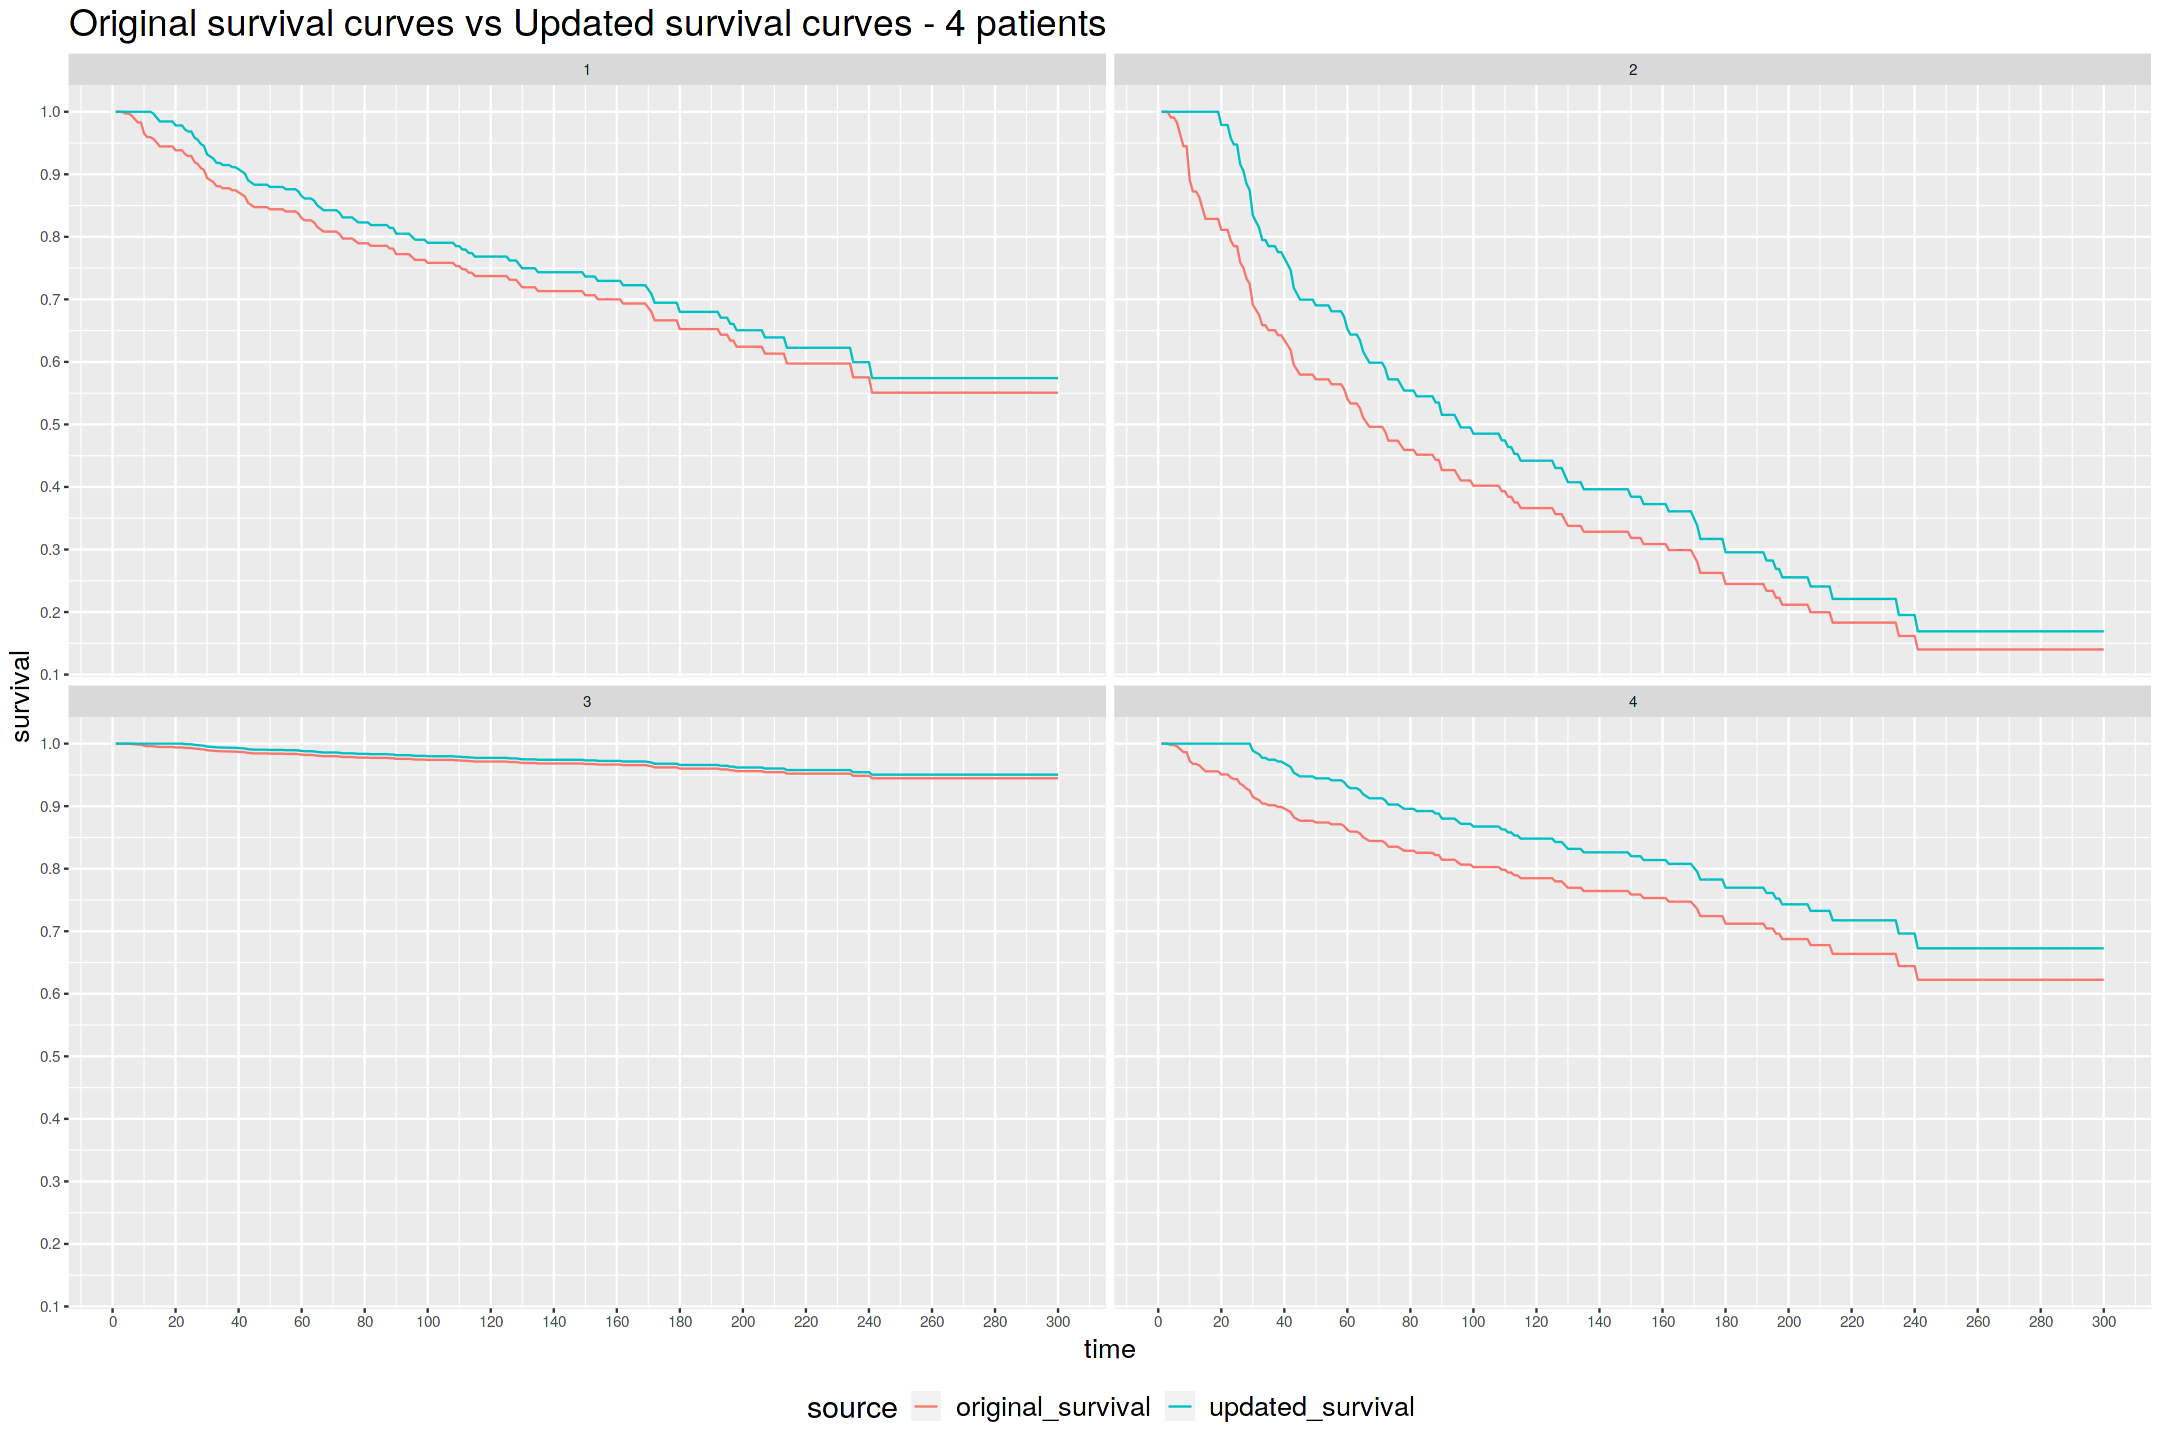

In [16]:
censored_patients %>%
    select(patient_id, time, original_survival, updated_survival) %>%
    filter(patient_id < 5) %>%
    pivot_longer(cols = original_survival:updated_survival, 
                 names_to = "source", 
                 values_to = "survival") %>%
    ggplot(aes(x = time, y = survival, colour = source)) + 
    geom_line() + 
    facet_wrap(vars(patient_id)) + 
    ggtitle("Original survival curves vs Updated survival curves - 4 patients") + 
    scale_y_continuous(breaks = seq(0, 1, 0.1)) + 
    scale_x_continuous(breaks = seq(0, 300, 20)) + 
    theme(plot.title = element_text(size = 22),  
          axis.title = element_text(size = 16), 
          legend.title = element_text(size = 18), 
          legend.text = element_text(size = 16), 
          legend.position = "bottom")